In [74]:
data_path1 = '資料/水位雨量資料/1510H071.csv'
prd_timestamp1 = '2022-05-29 23:00:00'
prd_timestamp2 = '2022-03-22 23:00:00'
prd_timestamp3 = '2022-08-18 23:00:00'

In [75]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from scipy import stats
from scipy.stats import norm,skew
import warnings
from sklearn.preprocessing import RobustScaler
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score

# 讀取數據
data_path = data_path1
data = pd.read_csv(data_path)

# 定義 時間索引 欄位
def create_timestamp(data):
    # 將"Date"和"Time"合併成時間戳記並設置為索引
    data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
    data = data.set_index('Timestamp')
    return data

# 原始資料加入時間索引
data = create_timestamp(data)
print (data)
data.head(5)



                           Date   Time  1510H071 Water Level  19606 Rainfall
Timestamp                                                                   
2020-01-01 00:00:00    2020/1/1  00:00                 20.58        0.000000
2020-01-01 01:00:00    2020/1/1  01:00                 20.80        0.000000
2020-01-01 02:00:00    2020/1/1  02:00                 20.81        0.000000
2020-01-01 03:00:00    2020/1/1  03:00                 20.80        0.000000
2020-01-01 04:00:00    2020/1/1  04:00                 20.79        0.000000
...                         ...    ...                   ...             ...
2022-12-31 19:00:00  2022/12/31  19:00                 19.22        0.000000
2022-12-31 20:00:00  2022/12/31  20:00                 19.22        0.065994
2022-12-31 21:00:00  2022/12/31  21:00                 19.21        0.057345
2022-12-31 22:00:00  2022/12/31  22:00                 19.21        0.000000
2022-12-31 23:00:00  2022/12/31  23:00                 19.21        0.065994

,Date,Time,1510H071 Water Level,19606 Rainfall
Timestamp,,,,
2020-01-01 00:00:00,2020/1/1,00:00,20.58,0.0
2020-01-01 01:00:00,2020/1/1,01:00,20.80,0.0
2020-01-01 02:00:00,2020/1/1,02:00,20.81,0.0
2020-01-01 03:00:00,2020/1/1,03:00,20.80,0.0
2020-01-01 04:00:00,2020/1/1,04:00,20.79,0.0


In [76]:
# 獲取列名
column_names = data.columns.tolist()

# 找到包含“Water Level”和“Rainfall”的列
water_level_columns = [col for col in column_names if 'Water Level' in col]
rainfall_columns = [col for col in column_names if 'Rainfall' in col]

# 選擇第一個符合條件的列
columns1 = water_level_columns[0] if water_level_columns else None
columns2 = rainfall_columns[0] if rainfall_columns else None

# 列名
if columns1:
    new_columns1_1 = f"{columns1}_monthly_mean"
    new_columns1_2 = f"{columns1}_distance"
    target_column_name = f"{columns1}_target_1"

print(new_columns1_1, new_columns1_2, target_column_name)

1510H071 Water Level_monthly_mean 1510H071 Water Level_distance 1510H071 Water Level_target_1


In [77]:
# 水位四舍五入小数第一位
data[columns1] = data[columns1].round(2)

# 列出所有要增加特徵的欄位名稱
columns_to_expand = [columns1, columns2]

# 1.產出_T-1到_T-72的特徵
for col in columns_to_expand:
    for t in range(1, 73):
        new_col_name = f"{col}_T-{t}"
        data[new_col_name] = data[col].shift(t)

# 2.產出每個月的平均水位
monthly_mean = data.groupby(data.index.month)[columns1].transform('mean')
data[new_columns1_1] = monthly_mean

# 3. 創建水位距平值：當前水位(T-0)和(T-1~T-72)與月平均水位的差值
data[new_columns1_2] = data[columns1] - monthly_mean

for t in range(1, 73):
    new_col_name = f"{columns1}_distance_T-{t}"
    data[new_col_name] = data[new_columns1_2].shift(t)

# 4.計算3、6、9、12、24、48、72小時的累積雨量
time_intervals = [3, 6, 9, 12, 24, 48, 72]

for interval in time_intervals:
    col_name = f"{columns2}_{interval}h_cumsum"
    data[col_name] = data[columns2].rolling(window=interval).sum()

# 5.增加T+1的雨量
for station in [columns2]:
    col = f"{station}"
    for t in range(1, 2):
        future_col_name = f"{col}_T+{t}"
        data[future_col_name] = data[col].shift(-t)

# 刪除包含NaN的行
data = data.dropna()

# 刪除不必要的列
data = data.drop(['Date', 'Time'], axis=1)

print(data)

                     1510H071 Water Level  19606 Rainfall  \
Timestamp                                                   
2020-01-04 00:00:00                 20.44        0.000000   
2020-01-04 01:00:00                 20.56        0.000000   
2020-01-04 02:00:00                 20.56        0.000000   
2020-01-04 03:00:00                 20.56        0.000000   
2020-01-04 04:00:00                 20.56        0.000000   
...                                   ...             ...   
2022-12-31 18:00:00                 19.22        0.000000   
2022-12-31 19:00:00                 19.22        0.000000   
2022-12-31 20:00:00                 19.22        0.065994   
2022-12-31 21:00:00                 19.21        0.057345   
2022-12-31 22:00:00                 19.21        0.000000   

                     1510H071 Water Level_T-1  1510H071 Water Level_T-2  \
Timestamp                                                                 
2020-01-04 00:00:00                     20.52           

In [78]:
# 特徵輸出
df = pd.DataFrame(data)

df.to_csv(f'{columns1}資料.csv', index=True)  # 如果不想保留索引，可以將 index 參數設為 False

In [79]:
# 標準化
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_features, columns=data.columns, index=data.index)

In [80]:
# 列出目標水位列
target_columns = [columns1]

# 增加目標列：T+1的目標水位
for target_col in target_columns:
    for t in range(1, 2):
        target = f'{target_col}_target_{t}'
        scaled_data[target] = data[target_col].shift(-t)

# 移除含有 NaN 的行
scaled_data = scaled_data.dropna()

In [81]:
# scaled_data

In [82]:
# # 使用 RandomizedSearchCV 選取區間最佳化參數
# from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
# from scipy.stats import uniform, randint
# import lightgbm as lgb

# # 切分數據為訓練和測試集
# X = scaled_data.drop([f'1510H057 Water Level_target_1'], axis=1)  # 特徵
# y = scaled_data[f'1510H057 Water Level_target_1']  # 目標變數

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# tscv = TimeSeriesSplit(n_splits=5)

# # 定義參數的範圍
# param_dist = {
#     'objective': ['regression'],  # 回歸問題
#     'num_leaves': randint(24, 35),  # 樹的最大葉子數
#     'learning_rate': uniform(0.01, 0.03),  # 學習率
#     'n_estimators': randint(650, 760),  # 樹的數量
#     'max_bin': randint(30, 50),  # 最大bin數量
#     'subsample': uniform(0.7, 0.85),  # 子樣本比例
#     'subsample_freq': randint(2, 5),  # 子樣本選擇頻率
#     'colsample_bytree': uniform(0.7, 0.85),  # 每棵樹使用特徵的比例
#     'min_child_samples': randint(4, 7),  # 每個葉子節點上的最小樣本數
#     'min_child_weight': randint(10, 13),  # 最小子節點權重和
#     'device': ['gpu'],  # 使用GPU進行計算
# }

# lgb_estimator = lgb.LGBMRegressor(silent=True, verbose=0)  # 定義LightGBM模型

# # 隨機搜索參數
# rsearch = RandomizedSearchCV(estimator=lgb_estimator,
#                              param_distributions=param_dist,
#                              n_iter=1000,  # 嘗試的參數組合次數
#                              cv=tscv,  # 使用時間序列交叉驗證
#                              verbose=1,
#                              n_jobs=5,  # 使用的CPU核心數
#                              random_state=42)

# rsearch.fit(X_train, y_train)  # 在訓練數據上進行隨機搜索

# # 輸出最佳參數和分數
# print('Best parameters found by random search are', rsearch.best_params_)
# print('Best score found by random search is', rsearch.best_score_)


In [83]:
#導入
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold,cross_val_score,train_test_split,cross_val_predict
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from math import sqrt
from tensorflow.keras.layers import TimeDistributed, Flatten
from lightgbm import early_stopping
from joblib import dump
import json

In [84]:
# MAPE計算函數
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


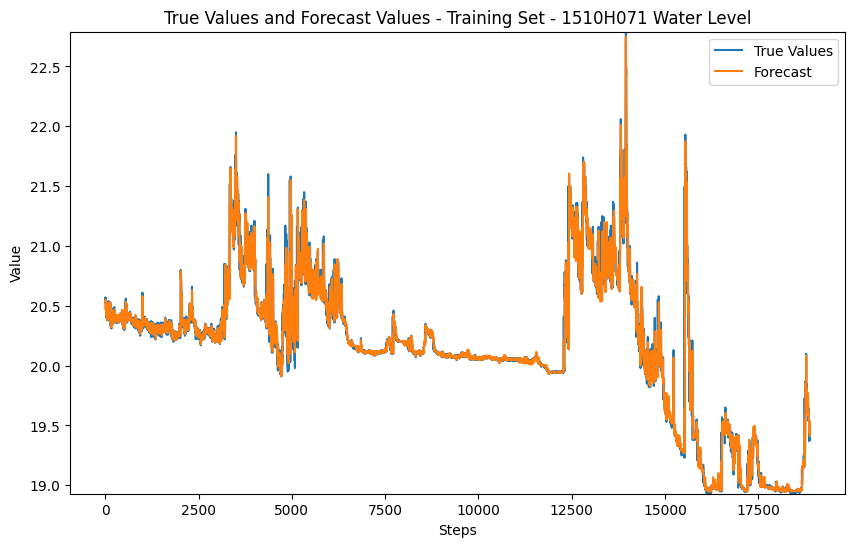

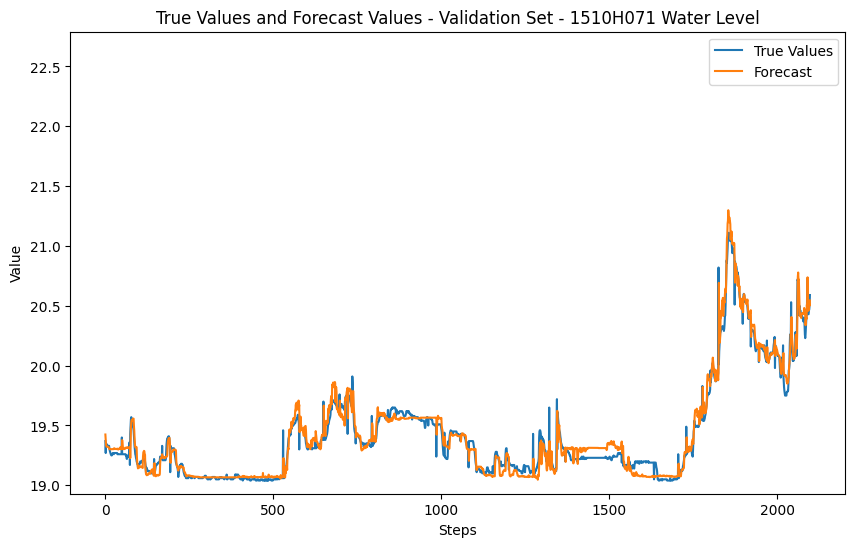

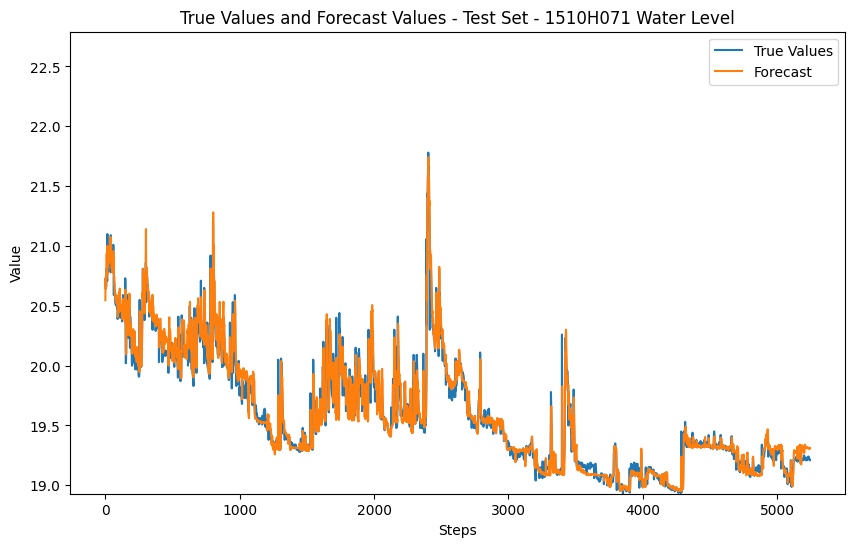

Important features:
1. 1510H071 Water Level - 930
2. 1510H071 Water Level_T-1 - 417
3. 1510H071 Water Level_distance - 408
4. 19606 Rainfall_T-56 - 277
5. 1510H071 Water Level_distance_T-23 - 255
6. 19606 Rainfall_T-31 - 218
7. 1510H071 Water Level_T-2 - 198
8. 19606 Rainfall_T-57 - 190
9. 19606 Rainfall_72h_cumsum - 182
10. 19606 Rainfall_T-54 - 170
11. 1510H071 Water Level_distance_T-71 - 169
12. 1510H071 Water Level_T-47 - 168
13. 19606 Rainfall_24h_cumsum - 161
14. 1510H071 Water Level_distance_T-47 - 159
15. 19606 Rainfall_T-55 - 158
16. 19606 Rainfall_48h_cumsum - 155
17. 1510H071 Water Level_distance_T-1 - 153
18. 1510H071 Water Level_T-23 - 153
19. 1510H071 Water Level_T-71 - 144
20. 1510H071 Water Level_distance_T-72 - 142


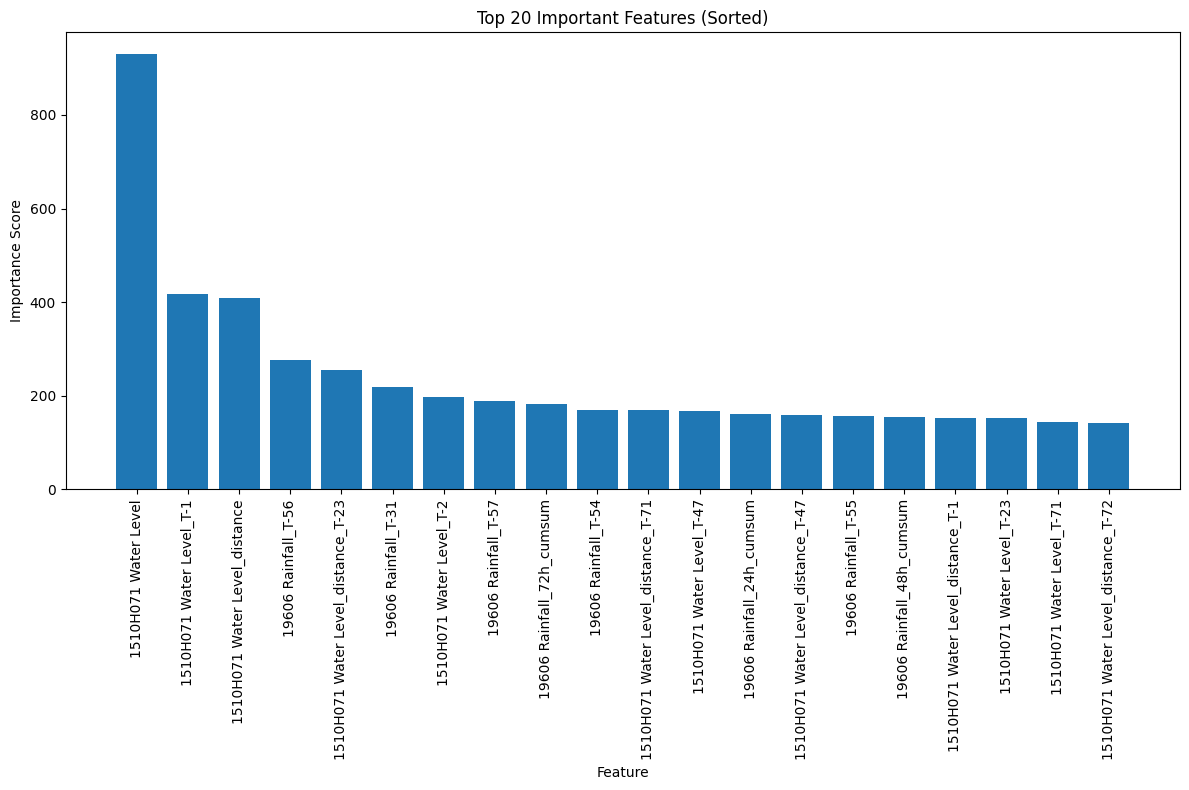

-------------------------------------------------------------------------


In [85]:
# 設定隨機種子
seed_value = 42

# 分割數據集為訓練和測試集
train_size = int(len(scaled_data) * 0.8)
val_size = int(train_size * 0.1)
train_data = scaled_data[:train_size-val_size]
val_data = scaled_data[train_size-val_size:train_size]
test_data = scaled_data[train_size:]

X_train = train_data.drop([target_column_name], axis=1)
y_train = train_data[target_column_name]

X_val = val_data.drop([target_column_name], axis=1)
y_val = val_data[target_column_name]

X_test = test_data.drop([target_column_name], axis=1)
y_test = test_data[target_column_name]

# 訓練 LightGBM 模型
model = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=24,
    learning_rate=0.03366781071846638,
    n_estimators=675,
    max_bin=40,
    subsample=0.7124500581816137,
    subsample_freq=3,
    colsample_bytree=0.8784303388858438,
    min_child_samples=5,
    min_child_weight=10,
    verbose=0,
    device='gpu',
    random_state=seed_value
)
model.fit(X_train, y_train)

# 儲存模型和特徵名稱
if not os.path.exists("model"):
    os.makedirs("model")
dump(model, 'model/lgb_model.joblib')

# Save the feature names as a JSON file
with open('model/feature_names.json', 'w') as f:
    json.dump(list(X_train.columns), f)

# 定義多步預測函數
def recursive_forecast(model, X_test, y_test):
    forecast = []          # 存儲預測結果的列表
    true_values = []       # 存儲真實目標值的列表

    for i in range(len(X_test)):
        # 提取真实的目标值
        true_value = y_test.iloc[i]
        true_values.append(true_value)

        # 使用特征进行预测
        pred = model.predict(X_test.iloc[i].values.reshape(1, -1))
        forecast.append(pred[0])

    # 現在我們在循環外部計算R²和MAPE分數
    r2_score_value = r2_score(true_values, forecast)
    mape_score_value = mean_absolute_percentage_error(true_values, forecast)

    return forecast, true_values, r2_score_value, mape_score_value


# 找到全局最大值和最小值
global_min = min(y_train.min(), y_val.min(), y_test.min())
global_max = max(y_train.max(), y_val.max(), y_test.max())

# 進行多步預測並評估結果
sets = [
    ("Training Set", X_train, y_train),
    ("Validation Set", X_val, y_val),
    ("Test Set", X_test, y_test)
]
scores = []

for set_name, X, y in sets:
    forecast, true_values, r2_scores, mape_scores = recursive_forecast(model, X.reset_index(drop=True), y.reset_index(drop=True))
    scores.append((set_name, r2_scores, mape_scores))

    # 真實值與預測值繪圖
    plt.figure(figsize=(10,6))
    plt.plot(true_values, label='True Values')
    plt.plot(forecast, label='Forecast')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Value')
    plt.title(f'True Values and Forecast Values - {set_name} - {columns1}')
    plt.ylim(global_min, global_max)  # 設置y軸的限制
    if not os.path.exists("picture"):
        os.makedirs("picture")

    # 保存图像到 'picture' 文件夹
    plt.savefig(f'picture/{set_name}_{columns1}.png')
    plt.show()
    
    # 儲存結果與分數
    results_df = pd.DataFrame({
        'Timestamp': pd.date_range(start='2023-01-01', periods=len(forecast), freq='H'),
        'True_Values': true_values,
        'Forecast': forecast
    })
    scores_df = pd.DataFrame(scores, columns=['Set', 'R2_Scores', 'MAPE_Scores'])

    # 保存结果到一个Excel文件
    with pd.ExcelWriter(f'{columns1}_results.xlsx') as writer:
        results_df.to_excel(writer, sheet_name='Results', index=False)
        scores_df.to_excel(writer, sheet_name='Scores', index=False)
    
# 取得重要特徵名稱與重要評分
feature_importances = model.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]  
top_20_indices = sorted_indices[:20]  

top_20_features = X_train.columns[top_20_indices]  
top_20_importances = feature_importances[top_20_indices]  

print("Important features:")
for i, (feature_name, score) in enumerate(zip(top_20_features, top_20_importances)):
    print(f"{i+1}. {feature_name} - {score}")

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_20_features)), top_20_importances, tick_label=top_20_features)  
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Top 20 Important Features (Sorted)')
plt.xticks(rotation=90)
plt.tight_layout()
if not os.path.exists("picture"):
    os.makedirs("picture")

# 保存图像到 'picture' 文件夹
plt.savefig(f'picture/Top 20 Important Features {columns1}.png')
plt.show()  

print("-------------------------------------------------------------------------")

In [86]:
# # 將分割後的資料儲存到Excel文件中
# with pd.ExcelWriter('data_splits.xlsx') as writer:
#     train_data.to_excel(writer, sheet_name='Train Data', index=False)
#     val_data.to_excel(writer, sheet_name='Validation Data', index=False)
#     test_data.to_excel(writer, sheet_name='Test Data', index=False)

In [87]:
def recursive_forecast(model, X_test, y_test, steps=288):
    forecast = []
    true_values = []
    r2_scores = []
    mape_scores = []

    for i in range(steps):
        true_value = y_test.iloc[i]
        true_values.append(true_value)
        
        pred = model.predict(X_test.iloc[i].values.reshape(1, -1))
        forecast.append(pred[0])

        r2 = r2_score(true_values, forecast)
        mape = mean_absolute_percentage_error(true_values, forecast)
        
        r2_scores.append(r2)
        mape_scores.append(mape)
    
    return forecast, true_values, r2_scores, mape_scores


T+1 to T+288 Average R²: 0.3910310182655647, Average MAPE: 0.3196743286407184
The results have been saved to '2022-08-18_23-00-00_1510H071 Water Level_target_1.xlsx'


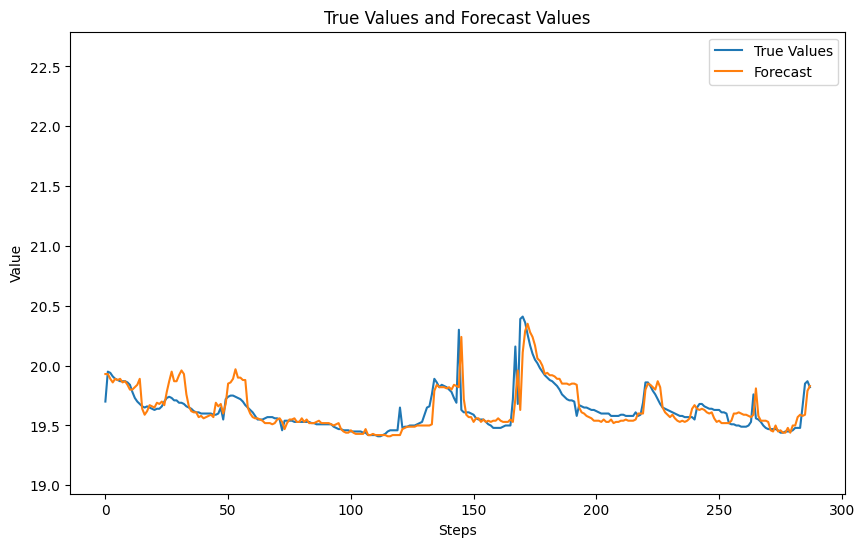

In [88]:
from joblib import load
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import json
from datetime import datetime

# 加载模型和特征名字
model = load('model/lgb_model.joblib')
with open('model/feature_names.json', 'r') as f:
    feature_names = json.load(f)
    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def forecast_from_timestamp(timestamp_str, steps=288):
    timestamp = pd.to_datetime(timestamp_str)
    idx_start = data.index.get_loc(data.loc[data.index >= timestamp].index[0])
    idx_end = idx_start + steps

    # 獲取對應的X_test和y_test
    X_test = scaled_data.iloc[idx_start:idx_end].drop([target_column_name], axis=1).reset_index(drop=True)
    y_test = scaled_data.iloc[idx_start:idx_end][target_column_name].reset_index(drop=True)

    # 進行多步預測
    forecast, true_values, r2_scores, mape_scores = recursive_forecast(model, X_test, y_test)

    # 四捨五入預測值到小數點後兩位
    forecast = np.round(forecast, 2)
    
    # T+1時刻的R²和MAPE
    r2_t1 = r2_scores[0]
    mape_t1 = mape_scores[0]

    # T+1到T+288的平均R²和MAPE
    avg_r2 = np.nanmean(r2_scores)
    avg_mape = sum(mape_scores) / len(mape_scores)

    print(f"T+1 to T+288 Average R²: {avg_r2}, Average MAPE: {avg_mape}")


    results_df = pd.DataFrame({
        'Step': list(range(1, steps + 1)),
        'True Values': true_values,
        'Forecast Values': forecast,
        'R² Score': r2_scores,
        'MAPE Score': mape_scores
    })

    avg_scores_df = pd.DataFrame({
        'Metric': ['Average R²', 'Average MAPE'],
        'Score': [avg_r2, avg_mape]
    })


    descriptive_filename = f"{timestamp_str.replace(' ', '_').replace(':', '-')}_{target_column_name}.xlsx"

    with pd.ExcelWriter(descriptive_filename) as writer:
        results_df[['Step', 'True Values', 'Forecast Values']].to_excel(writer, sheet_name='Values', index=False)
        results_df[['Step', 'R² Score', 'MAPE Score']].to_excel(writer, sheet_name='Scores', index=False)
        
        avg_scores_df.to_excel(writer, sheet_name='Scores', startrow=len(results_df) + 2, index=False)

    print(f"The results have been saved to '{descriptive_filename}'")
    
    # 真實值與預測值繪圖
    plt.figure(figsize=(10,6))
    plt.plot(true_values, label='True Values')
    plt.plot(forecast, label='Forecast')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Value')
    plt.title('True Values and Forecast Values')
    plt.ylim(global_min, global_max)  # 設定y軸的限制
    if not os.path.exists("picture"):
        os.makedirs("picture")

    # 保存图像到 'picture' 文件夹
    plt.savefig(f'{descriptive_filename}.png')    
    plt.show()


# 使用函數進行預測
forecast_from_timestamp(prd_timestamp1)
forecast_from_timestamp(prd_timestamp2)
forecast_from_timestamp(prd_timestamp3)

In [89]:
# from joblib import dump
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.metrics import r2_score, mean_absolute_error

# def forecast_from_timestamp(timestamp_str, steps=288):
#     timestamp = pd.to_datetime(timestamp_str)
#     idx_start = data.index.get_loc(data.loc[data.index >= timestamp].index[0])
#     idx_end = idx_start + steps

#     # 獲取對應的X_test和y_test
#     X_test = scaled_data.iloc[idx_start:idx_end].drop([target_column_name], axis=1).reset_index(drop=True)
#     y_test = scaled_data.iloc[idx_start:idx_end][target_column_name].reset_index(drop=True)

#     # 進行多步預測
#     forecast, true_values, r2_scores, mape_scores = recursive_forecast(model, X_test, y_test)

#     # T+1時刻的R²和MAPE
#     r2_t1 = r2_scores[0]
#     mape_t1 = mape_scores[0]

#     # T+1到T+288的平均R²和MAPE
#     avg_r2 = np.nanmean(r2_scores)
#     avg_mape = sum(mape_scores) / len(mape_scores)

#     print(f"T+1 R²: {r2_t1}, T+1 MAPE: {mape_t1}")
#     print(f"T+1 to T+288 Average R²: {avg_r2}, Average MAPE: {avg_mape}")

#     # 真實值與預測值繪圖
#     plt.figure(figsize=(10,6))
#     plt.plot(true_values, label='True Values')
#     plt.plot(forecast, label='Forecast')
#     plt.legend()
#     plt.xlabel('Steps')
#     plt.ylabel('Value')
#     plt.title('True Values and Forecast Values')
#     plt.ylim(global_min, global_max)  # 設定y軸的限制
#     plt.show()

#     return forecast, true_values, r2_scores, mape_scores

# # 使用函數進行預測
# forecast_from_timestamp(prd_timestamp)



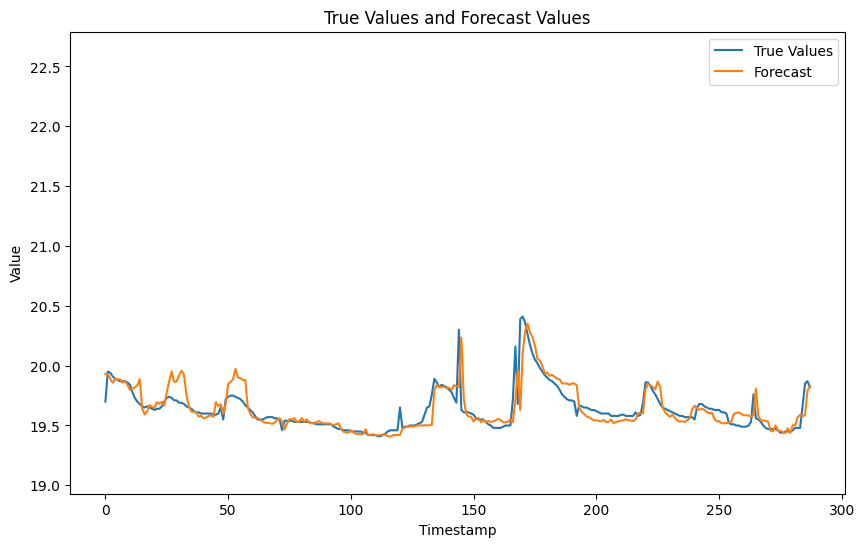

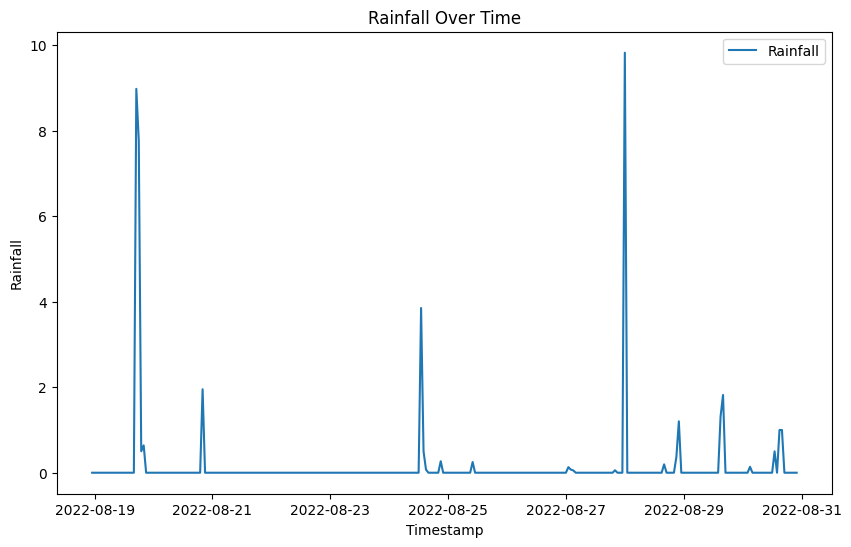

([19.932048617987082,
  19.928975930072674,
  19.888937783485193,
  19.857048535336087,
  19.888262158601616,
  19.88368854834309,
  19.886442293979435,
  19.857929799074057,
  19.87015979489204,
  19.840486164048745,
  19.795863160421185,
  19.80439248704758,
  19.81914143965119,
  19.835956790379797,
  19.887611905017152,
  19.64314110228086,
  19.592005613502927,
  19.619464018385678,
  19.670276949713212,
  19.655608159231612,
  19.64858443232421,
  19.69498413116629,
  19.682447036613922,
  19.697588810901152,
  19.66617563964699,
  19.777500531612038,
  19.867839676256494,
  19.951288627690484,
  19.86533816345985,
  19.867901934303863,
  19.918392279188144,
  19.95748111203561,
  19.92823118518467,
  19.756574123330974,
  19.660059161592304,
  19.61671634815726,
  19.614550634269705,
  19.614415832148275,
  19.573419579089272,
  19.58167689197462,
  19.55964266597986,
  19.56591543131983,
  19.579176848062787,
  19.585647730176046,
  19.572324168692663,
  19.694533086722508,
  1

In [90]:
def forecast_from_timestamp(timestamp_str, steps=288):
    timestamp = pd.to_datetime(timestamp_str)
    idx_start = data.index.get_loc(data.loc[data.index >= timestamp].index[0])
    idx_end = idx_start + steps

    X_test = scaled_data.iloc[idx_start:idx_end].drop([target_column_name], axis=1).reset_index(drop=True)
    y_test = scaled_data.iloc[idx_start:idx_end][target_column_name].reset_index(drop=True)

    # 多部預測
    forecast, true_values, r2_scores, mape_scores = recursive_forecast(model, X_test, y_test, steps=steps)

    # 真實值與預測值繪圖
    plt.figure(figsize=(10,6))
    plt.plot(true_values, label='True Values')
    plt.plot(forecast, label='Forecast')
    plt.legend()
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title('True Values and Forecast Values')
    plt.ylim(global_min, global_max)  # 设定y轴的限制
    plt.show()

    # 獲得雨量數據
    scaled_rainfall = scaled_data.iloc[idx_start:idx_end][columns2].values.reshape(-1,1)
    
    # 創建副本
    all_features_scaled = scaled_data.iloc[idx_start:idx_end].drop([target_column_name], axis=1).copy()
    
    # 反標準化的直替代雨量的值
    all_features_scaled[columns2] = scaled_rainfall.ravel()
    
    # 反標準化
    all_features_original = scaler.inverse_transform(all_features_scaled.values)
    
    # 獲得雨量反標準化特徵
    original_rainfall = all_features_original[:, scaled_data.columns.get_loc(columns2)]
    # 繪製
    plt.figure(figsize=(10,6))
    plt.plot(data.index[idx_start:idx_end], original_rainfall, label='Rainfall')
    plt.xlabel('Timestamp')
    plt.ylabel('Rainfall')
    plt.title('Rainfall Over Time')
    plt.legend()
    plt.show()

    return forecast, true_values, r2_scores, mape_scores

# 使用函數進行預測
forecast_from_timestamp(prd_timestamp1)
forecast_from_timestamp(prd_timestamp2)
forecast_from_timestamp(prd_timestamp3)
